# Kernel Mixture Network class
Notebook to perform interactive tests.

In [1]:
import sys

sys.path.append('../')

import numpy as np
import pandas as pd

# neural networks
import keras
import edward as ed
import tensorflow as tf

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
%matplotlib inline

# module loading settings
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


## Toy dataset

Size of features in training data: (3750, 1)
Size of output in training data: (3750,)
Size of features in test data: (1250, 1)
Size of output in test data: (1250,)


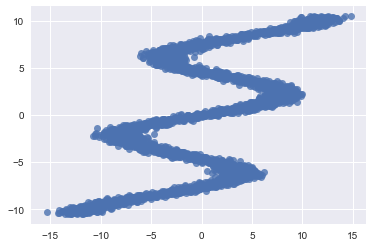

In [2]:
from sklearn.model_selection import train_test_split

def build_toy_dataset(n):
    np.random.seed(41)
    y_data = np.random.uniform(-10.5, 10.5, n)
    r_data = np.random.normal(size=n)  # random noise
    x_data = np.sin(0.75 * y_data) * 7.0 + y_data * 0.5 + r_data * 1.0
    x_data = x_data.reshape((n, 1))
    return train_test_split(x_data, y_data, random_state=42)

n_observations = 5000  # number of data points
n_features = 1  # number of features

X_train, X_test, y_train, y_test = build_toy_dataset(n_observations)
print("Size of features in training data: {}".format(X_train.shape))
print("Size of output in training data: {}".format(y_train.shape))
print("Size of features in test data: {}".format(X_test.shape))
print("Size of output in test data: {}".format(y_test.shape))

sns.regplot(X_train, y_train, fit_reg=False);

## Initialize and train network

In [3]:
from src.kmn import KernelMixtureNetwork

kmn = KernelMixtureNetwork(train_scales=True)
kmn.fit(X_train, y_train, n_epoch=300, eval_set=(X_test, y_test))

fitting model
300/300 [100%] ██████████████████████████████ Elapsed: 5s | Loss: 6896.890
mean log-loss train: 1.839
man log-loss test: 1.929
optimal scales: [ 0.48022652]


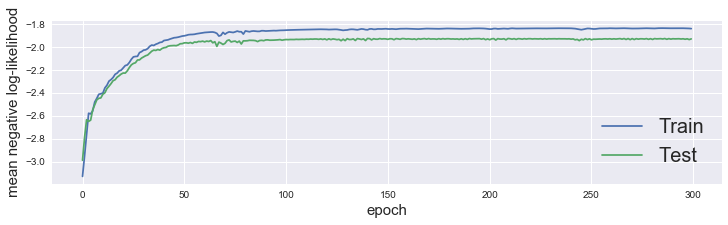

In [4]:
kmn.plot_loss();

## Sample $y$ conditioned on test $x$ and look at densities of first 3 test $x$

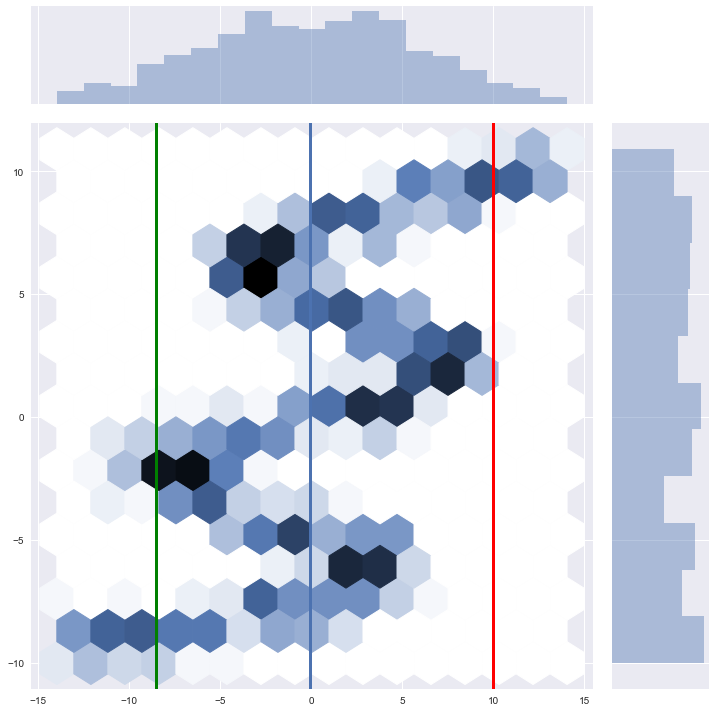

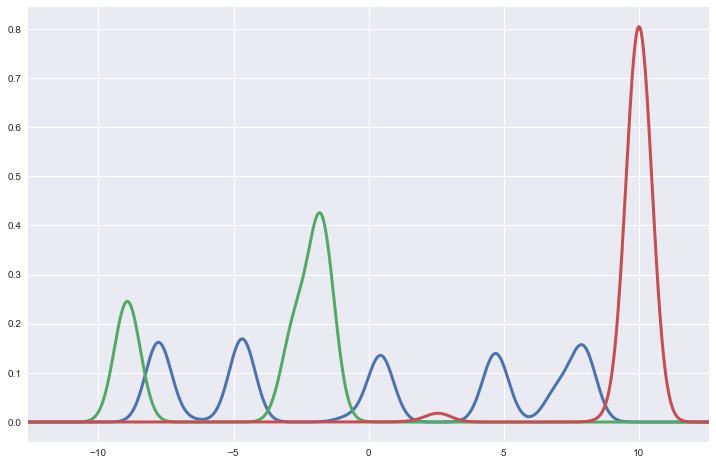

In [15]:
samples = kmn.sample(X_test)
jp = sns.jointplot(X_test.ravel(), samples, kind="hex", stat_func=None, size=10)
jp.ax_joint.add_line(Line2D([X_test[0][0], X_test[0][0]], [-40, 40], linewidth=3))
jp.ax_joint.add_line(Line2D([X_test[1][0], X_test[1][0]], [-40, 40], color='g', linewidth=3))
jp.ax_joint.add_line(Line2D([X_test[2][0], X_test[2][0]], [-40, 40], color='r', linewidth=3))
plt.savefig('hexplot.png')
plt.show()
d = kmn.predict_density(X_test[0:3,:].reshape(-1,1), resolution=1000)
df = pd.DataFrame(d).transpose()
df.index = np.linspace(kmn.y_min, kmn.y_max, num=1000)
df.plot(legend=False, linewidth=3, figsize=(12.2, 8))
plt.savefig('conditional_density.png')

## Define custom Keras or Tensorflow network as start of KMN

In [8]:
from keras.layers import Dense

X_ph = tf.placeholder(tf.float32, [None, n_features])
x = Dense(32, activation='relu')(X_ph)
x = Dense(16, activation='relu')(x)
neural_network = Dense(8, activation='relu')(x)

kmn = KernelMixtureNetwork(estimator=neural_network, X_ph=X_ph, train_scales=False)
kmn.fit(X_train, y_train, n_epoch=300)

fitting model
300/300 [100%] ██████████████████████████████ Elapsed: 3s | Loss: 7911.503
mean log-loss train: 2.110
optimal scales: [ 1.]
